In [85]:
import json
import os
import sys
import importlib
from datetime import datetime
from pathlib import Path
from pprint import pprint

import requests


# Setup environment
if 'google.colab' in sys.modules:
    if not Path('rl-attention').exists():
        !git clone --quiet https://github.com/Pastafarianist/rl-attention.git
    else:
        %cd rl-attention/
        !git pull origin master
        %cd ..
        
    if 'rl-attention' not in sys.path:
        sys.path.append('rl-attention')
        
    config_path = Path('rl-attention/config.json')
else:
    config_path = Path('config.json')

# Read config
with config_path.open() as fp:
    cfg = json.load(fp)
    print('Original config:')
    pprint(cfg)

# Change config here
custom_cfg = {
    
}

# Update config
if custom_cfg:
    cfg.update(custom_cfg)
    print()
    print('Modified config:')
    pprint(cfg)

# Generate run ID
if 'run_ts' not in globals():
    run_ts = datetime.now().isoformat(sep='_', timespec='milliseconds').replace(':', '-')
run_name = '{env_name},{algo},{network},{train_seed},{run_ts}'.format(run_ts=run_ts, **cfg)
print('Run ID is {}'.format(run_name))

from bootstrap import setup_environment
output_dir = setup_environment(
    run_name=run_name,
    ssh_keys=(
        key
        for username in ['Pastafarianist', 'HoagyC', 'fabiansteuer', 'skosch', 'RerRayne']
        for key in requests.get('https://github.com/{}.keys'.format(username)).text.split('\n')
        if key
    )
)

# Setup legacy logging from baselines (useful for comparisons)
from stable_baselines.logger import configure

log_dir = output_dir / cfg['log_dir']
tensorboard_dir = output_dir / cfg['tb_dir']
configure(
    log_dir=str(log_dir),
    format_strs=['log', 'csv', 'tensorboard'],
    tensorboard_dir=str(tensorboard_dir)
)

/content/rl-attention
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/Pastafarianist/rl-attention
 * branch            master     -> FETCH_HEAD
   0b2e567..b6375bd  master     -> origin/master
Updating 0b2e567..b6375bd
Fast-forward
 k_means.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)
/content
Original config:
{'algo': 'ppo2',
 'attn_coef': 0.001,
 'attn_loss': 'attention_entropy',
 'env_name': 'BreakoutNoFrameskip-v4',
 'log_dir': 'logs',
 'log_interval': 1,
 'network': 'attention_cnn',
 'normalize': False,
 'policy_type': 'CnnPolicy',
 'tb_dir': 'tb',
 'time_steps': 10000000,
 'train_seed': 0,
 'train_time': 0}
Run ID is BreakoutNoFrameskip-v4,ppo2,attention_cnn,0,2019-05-03_14-04-17.078
Running on Colab
ssh tunnel is already open, connect via:
ssh -o StrictHostKeyChecking

In [0]:
import gym
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import stable_baselines
importlib.reload(stable_baselines)
from stable_baselines import PPO2
from stable_baselines.common import set_global_seeds
from stable_baselines.common.cmd_util import make_atari_env
from stable_baselines.common.vec_env import VecFrameStack, VecNormalize

from tqdm import tqdm_notebook

# Load and re-load modules just to make sure they're up to date
import models; importlib.reload(models)
import losses; importlib.reload(losses)
import saliency_renderer; importlib.reload(saliency_renderer)
import deep_saliency_tree_renderer; importlib.reload(deep_saliency_tree_renderer)
import k_means; importlib.reload(k_means)

from models import get_network_builder
from losses import get_loss
from saliency_renderer import SaliencyRenderer
from deep_saliency_tree_renderer import DeepSaliencyTreeRenderer
from k_means import filter_k

import json, codecs

In [0]:
import tensorflow as tf
import numpy as np
import math

class DeepSaliencyTreeRenderer2():
    def __init__(self, callback_locals, feed_dict):
        self.session = callback_locals['self'].sess
        self.graph = callback_locals['self'].graph
        self.env = callback_locals['self'].env
        self.feed_dict = feed_dict


    def find_most_relevant_nodes(self, layer, relevance_values, layer_values, current_batch_index, ymin, xmin):
        """Find most relevant neurons, using softmax, distance, and/or some cutoff.
        Find tensor based on activation or relevance
        Use scipy.signal.find_peaks with a prominence minimum to find peaks"""

        # peak_indices = scipy.signal.find_peaks(values)    # one day we will use this

        # values.shape = [batch_size, h, w, channels]
        #peak_indices = [np.unravel_index(
         #   relevance_values.argmax(),
         #   relevance_values.shape)]
        #if relevance_values.shape[1] == 1 and relevance_values.shape[2] == 1:
        #peak_indices = list(zip(*np.unravel_index(np.argpartition(relevance_values, -3, axis=None)[-3:], relevance_values.shape)))
        #else:
        #print("Finding most relevant nodes, layer size", layer_geometry['size'])
        #print("Relevance values has shape", relevance_values.shape)
        top_x = int(np.floor(4*np.exp(-layer['size']*0.1)+2))
        
        #print("top x is", top_x)
        #print(relevance_values)
        k = int(np.floor(2*np.exp(layer['size'] * 0.06)))
        peak_indices = filter_k(relevance_values, order_method='max', k=k, top_x=top_x, top_f=3, method='peak')
        
        #print("Now looked for peak indices:")
        #plt.plot(np.ravel(relevance_values))
        #plt.show()
        #print("Found peaks:", peak_indices)
        
        # Cluster each filter channel activation into its centroid(s) by magnitude, using gap statistic
        # Find the magnitudes of the relevance at the centroids
        # Pick the top n centroids as sorted by their magnitude

        relevant_node_infos = []
        for i in peak_indices:
            lcc = layer['coordinate_converter']
            yc = i[0] + ymin
            xc = i[1] + xmin
            relevant_node_infos.append({
                'coordinates': [current_batch_index, yc, xc, i[2]],
                'global_coordinates': [current_batch_index, lcc(yc), lcc(xc), i[2]],
                'node': layer['pre_activation'][current_batch_index, yc, xc, i[2]],
                'layer': layer['pre_activation'],
                'weights': layer['input_weights'][:, :, :, i[2]],
                'size': layer['size'],
                'strides': layer['strides'],
                'raw_value': layer_values[0][current_batch_index, yc, xc, i[2]].item(),
                'activation_value': layer_values[1][current_batch_index, yc, xc, i[2]].item(),
                'relevance_value': relevance_values[i[0], i[1], i[2]].item(),
                'children': [],
            })

        return relevant_node_infos


    def update_relevant_children_for_node(self, node_info, child_layers, child_layer_values, current_batch_index):
        # 1. Calculate relevance scores for all input nodes to this node
        # 2. Select relevant input nodes based on relevance scores
        # 3. Call update_relevant_children_for_node on each of the new children
        # 4. Don't continue if input_layer is None
        
        input_weights = node_info['weights'] # 3D tensor, size (kernel_size, kernel_size, child_filters)

        hs = (node_info['size']-1)/2
        # The position of the node's coordinate in coordinates of the layer below
        yl = node_info['coordinates'][1] * node_info['strides'] + (node_info['size']-1)/2
        xl = node_info['coordinates'][2] * node_info['strides'] + (node_info['size']-1)/2
        # Extent of the node's receptive field in the lower layer
        rf_ymin = int(yl - hs)
        rf_ymax = int(yl + hs + 1)
        rf_xmin = int(xl - hs)
        rf_xmax = int(xl + hs + 1)
        
        input_activations = child_layer_values[1][current_batch_index, rf_ymin:rf_ymax, rf_xmin:rf_xmax, :]
        
        input_relevance_values = input_activations * input_weights # basic
        #input_relevance_values = (input_activations * input_weights) ** 2
        input_relevance_values = np.abs(input_activations * input_weights) / np.sum(np.abs(input_activations * input_weights))

        relevant_child_nodes = self.find_most_relevant_nodes(child_layers[-1], input_relevance_values, child_layer_values, current_batch_index, rf_ymin, rf_xmin)
        
        if len(child_layers) >= 2: # if there's another layer below the children we just found:
            grandchild_layer_values = self.session.run([child_layers[-2]['pre_activation'], child_layers[-2]['activation']], self.feed_dict)
            for child_node_info in relevant_child_nodes:
                child_node_info['children'] = self.update_relevant_children_for_node(child_node_info,
                                                                                     child_layers[:-1],
                                                                                     grandchild_layer_values,
                                                                                     current_batch_index)

        return relevant_child_nodes


    def get_relevance_tree_for_layers(self, layers):
        # Evaluate relevance score for each unit.
        #   - If attention layer is given, use activations and/or coordinates to find top k % of relevant neurons.
        # Pick the top k percent of neurons.
        # Create a list of those neurons, and also record their local coordinates, global coordinates, before_activation_value, and activation_value

        # Then, for each of the neurons, compute children.
        # Find children for each neuron by running get_relevance_tree_for_neuron
        #

        trees_by_batch = []
        for batch_index in range(self.session.run(layers[0]['pre_activation'], self.feed_dict).shape[0]):
            #print("Finding branch clusters for batch", batch_index)
            layer_values = self.session.run([layers[-1]['pre_activation'], layers[-1]['activation']], self.feed_dict) # np.array
            child_layer_values = self.session.run([layers[-2]['pre_activation'], layers[-2]['activation']], self.feed_dict)

            # use layer_values[1] here to use the softmax of the attention2
            relevant_node_infos = self.find_most_relevant_nodes(layers[-1], layer_values[1][batch_index, ...], layer_values, batch_index, 0, 0)

            for node_info in relevant_node_infos:
                 node_info['children'] = self.update_relevant_children_for_node(node_info, layers[:-1], child_layer_values, batch_index)

            trees_by_batch.append(relevant_node_infos)

        return trees_by_batch

    def add_layer_coordinate_converters(self, layers):
        def create_converter(lg, pl):
            conv = lambda c: ((lg['size']-1)/2 + lg['strides']*c) * pl['global_strides'] + (pl['global_size']-1)/2
            return conv

        for (li, lg) in enumerate(layers):
            lg['coordinate_converter'] = create_converter(lg, layers[li-1] if li >= 1 else {'global_strides': 1, 'global_size': 1})

        return layers

    def add_global_layer_sizes(self, layers):
        layers[0]['global_size'] = layers[0]['size']
        layers[0]['global_strides'] = layers[0]['strides']
        for (li, lg) in enumerate(layers[1:]):
            lg['global_size'] = layers[li]['global_size'] + (lg['size'] - 1) * layers[li]['global_strides']
            lg['global_strides'] = layers[li]['global_strides'] * lg['strides']
        return layers


    def draw_square(self, node, layer, parent_node, **kwargs):
        (y, x, c) = (node['global_coordinates'][1], node['global_coordinates'][2], node['global_coordinates'][3])
        hs = layer['global_size'] / 2
        plt.plot([x-hs, x+hs, x+hs, x-hs, x-hs], [y-hs, y-hs, y+hs, y+hs, y-hs], color='w', **kwargs)

    def draw_node(self, node, layer, parent_node, **kwargs):
        (y, x, c) = (node['global_coordinates'][1], node['global_coordinates'][2], node['global_coordinates'][3])
        plt.plot([x], [y], 'o', color=layer['color'], **kwargs)

    def draw_branch(self, node, layer, parent_node, **kwargs):
        (y, x, c) = (node['global_coordinates'][1], node['global_coordinates'][2], node['global_coordinates'][3])
        (py, px, pc) = (parent_node['global_coordinates'][1], parent_node['global_coordinates'][2], parent_node['global_coordinates'][3])
        plt.plot([x, px], [y, py], color='w', **kwargs)


    def plot_relevant_nodes(self, nodes, layers, parent_node=None):
        # plot a dot where the node is
        for n in nodes:
            #print("Layer", len(layers))
            if len(layers) == 1:
                #print("Center square", n['global_coordinates'])
                self.draw_square(n, layers[-1], parent_node)
            else:
                #print("Center node", n['global_coordinates'])
                self.draw_node(n, layers[-1], parent_node)

            if parent_node is not None:
                #print("and refer to parent", parent_node['global_coordinates'])
                self.draw_branch(n, layers[-1], parent_node)

            self.plot_relevant_nodes(n['children'], layers[:-1], n)
            
    def save_tree_and_attention(self, frame_index, rts, input_values, layers):
        class NumpyEncoder(json.JSONEncoder):
            def default(self, obj):
                if isinstance(obj, np.ndarray):
                    return obj.tolist()
                if tf.contrib.framework.is_tensor(obj):
                    return "Tensor (not serialized)"
                try:
                    return json.JSONEncoder.default(self, obj)
                except:
                    return "Could not encode this"
        
        out_json = {
            'rts': rts,
            'input_values': input_values,
            'frame_index': frame_index,
            'layers': layers,
        }
        
        file_path = "/tmp/" + str(frame_index) + ".json" ## your path variable
        json.dump(out_json, codecs.open(file_path, 'w', encoding='utf-8'), cls=NumpyEncoder, separators=(',', ':'), sort_keys=True, indent=4)
        ### this saves the array in .json format

    def plot_relevance_tree(self, layers, a2, input_values, frame_index):
        # get relevance tree
        layers = self.add_global_layer_sizes(layers)
        layers = self.add_layer_coordinate_converters(layers)

        rts = self.get_relevance_tree_for_layers(layers)
        # traverse through the tree
        for (batch_index, rt) in enumerate(rts):
            # plot activations
            plt.imshow(a2[batch_index, :, :, 0])
            plt.colorbar()
            plt.show()
            plt.imshow(a2[batch_index, :, :, 1])
            plt.colorbar()
            plt.show()
            # plot input frames
            
            plt.figure(figsize=(14, 10))
            plt.imshow(np.max(input_values[batch_index, :, :, :], axis=-1), cmap='gray')
            self.plot_relevant_nodes(rt, layers)
            plt.show()
            
            self.save_tree_and_attention(frame_index, rts, input_values, layers)


class Callback(object):
    def __init__(self, display_frames=False, display_saliency_map=False, display_deep_saliency_tree=False):
        self.display_frames = display_frames
        self.display_saliency_map = display_saliency_map
        self.display_deep_saliency_tree = display_deep_saliency_tree
        self.pbar = None
        self.frame_index = 0
    
    def __call__(self, _locals, _globals):
        if self.pbar is None:
            self.pbar = tqdm_notebook(total=_locals['nupdates'] * _locals['self'].n_batch)
        
        self.pbar.update(_locals['self'].n_batch)
        self.pbar.set_postfix_str('{update}/{nupdates} updates'.format(**_locals))
        
        self.session, self.graph, self.env = _locals['self'].sess, _locals['self'].graph, _locals['self'].env
        
        #pprint(self.graph.get_operations())
        input_values = self.env.stackedobs
        input_tensor = self.graph.get_tensor_by_name("train_model/input/Ob:0")
        input_cast_tensor = self.graph.get_tensor_by_name("train_model/input/Cast:0")
        c1_activations = self.graph.get_tensor_by_name("train_model/model/Relu:0")
        c2_activations = self.graph.get_tensor_by_name("train_model/model/Relu_1:0")
        c3_activations = self.graph.get_tensor_by_name("train_model/model/Relu_2:0")
        a1_activations = self.graph.get_tensor_by_name("train_model/model/Elu:0")
        a2_activations = self.graph.get_tensor_by_name("train_model/model/a2/add:0")
        a2_softmax = self.graph.get_tensor_by_name("train_model/model/attn:0")
        c1_input_weights = self.graph.get_tensor_by_name("model/c1/w:0")
        c2_input_weights = self.graph.get_tensor_by_name("model/c2/w:0")
        c3_input_weights = self.graph.get_tensor_by_name("model/c3/w:0")
        a1_input_weights = self.graph.get_tensor_by_name("model/a1/w:0")
        a2_input_weights = self.graph.get_tensor_by_name("model/a2/w:0")
        

        if _locals['update'] == _locals['nupdates']:
            self.pbar.close()
            self.pbar = None
        
        if _locals['update'] % 1 == 1 or _locals['update'] == _locals['nupdates'] or True:
            if self.display_frames:
                plt.grid(None)
                plt.imshow(_locals["self"].env.render(mode='rgb_array'))
                plt.show()
                
            if self.display_saliency_map:
                sr = SaliencyRenderer(_locals)
                smap = sr.get_basic_input_saliency_map(
                    input_tensor, input_values, input_cast_tensor, a2_activations, 
                    selection_method='SUM', n_gradient_samples=10, gradient_sigma_spread=0.15)
                plt.imshow(smap[0, :, :, 0])
                plt.colorbar()
                plt.show()
                
            if self.display_deep_saliency_tree:               
                layers = [
                   {
                       'pre_activation': c1_activations.op.inputs[0],
                       'activation': c1_activations,
                       'size': 8, 'strides': 4, 'color': 'white',
                       'input_weights': self.session.run(c1_input_weights),
                   },
                   {
                       'pre_activation': c2_activations.op.inputs[0],
                       'activation': c2_activations,
                       'size': 4, 'strides': 2, 'color': 'green',
                       'input_weights': self.session.run(c2_input_weights),
                   },
                   {
                       'pre_activation': c3_activations.op.inputs[0],
                       'activation': c3_activations,
                       'size': 3, 'strides': 1, 'color': 'red',
                       'input_weights': self.session.run(c3_input_weights),
                   },
                   {
                       'pre_activation': a1_activations.op.inputs[0],
                       'activation': a1_activations,
                       'size': 1, 'strides': 1, 'color': 'yellow',
                       'input_weights': self.session.run(a1_input_weights),
                   },
                   {
                       'pre_activation': a2_activations,
                       'activation': a2_softmax,
                       'size': 1, 'strides': 1, 'color': 'magenta',
                       'input_weights': self.session.run(a2_input_weights),
                   },
                ]

                dstr = DeepSaliencyTreeRenderer2(_locals, {input_tensor: input_values})
                dstr.plot_relevance_tree(layers, self.session.run(a2_softmax, {input_tensor: input_values}), input_values, self.frame_index)
            
            # Save current model
            self.frame_index += 1
            _locals['self'].save(str(output_dir / 'model.pkl'))

        return True

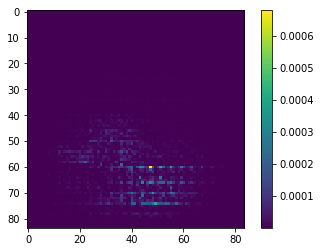

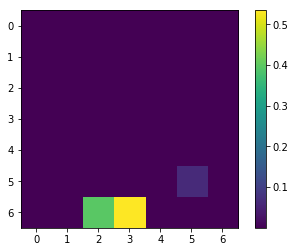

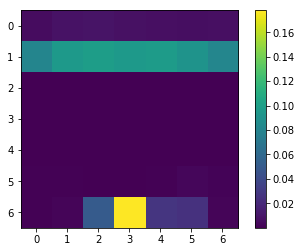

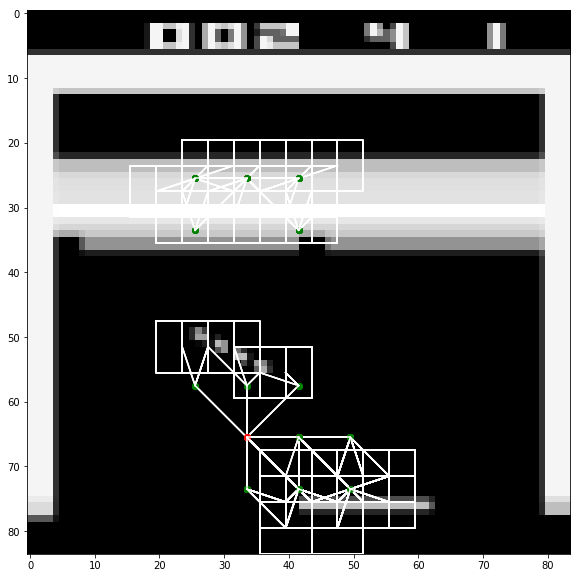

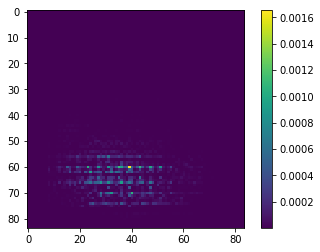

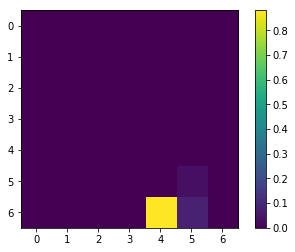

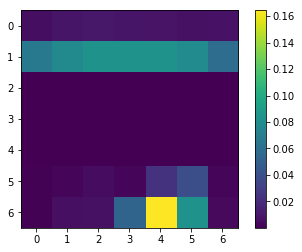

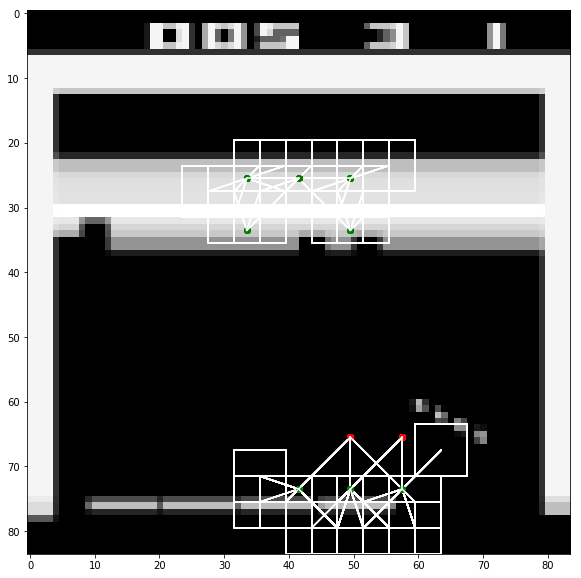

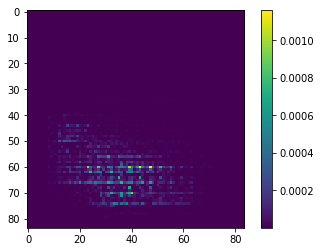

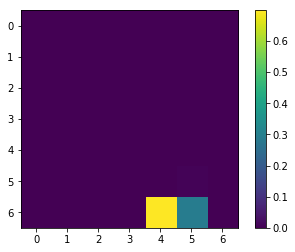

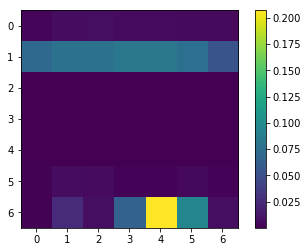

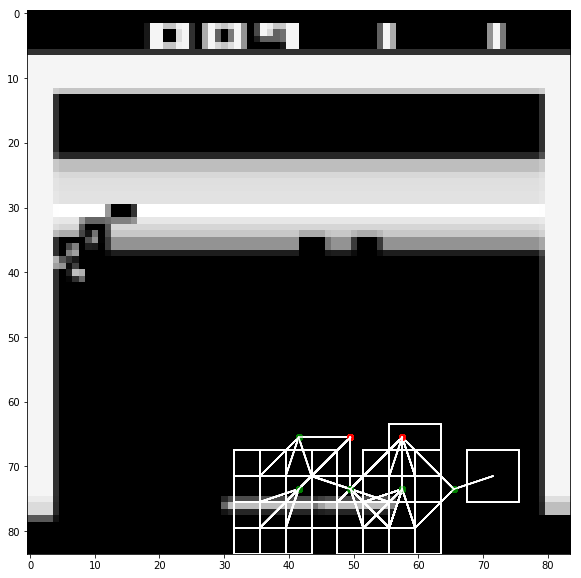

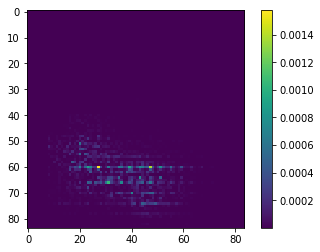

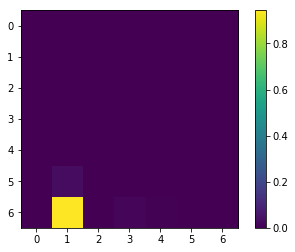

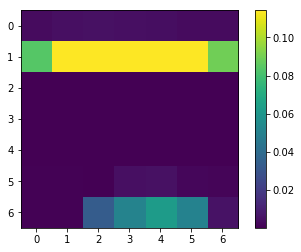

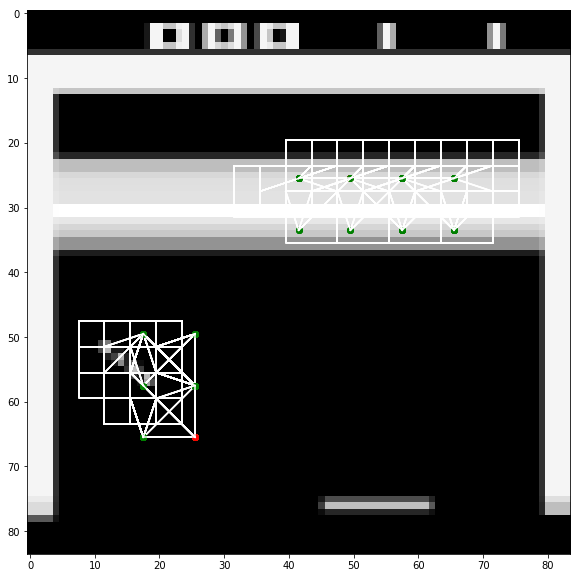

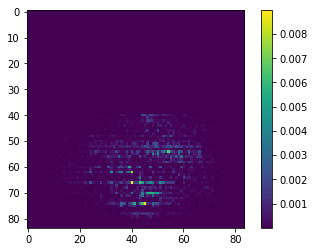

In [0]:
# Dump entire configuration
with (output_dir / 'config.json').open('w') as fp:
    json.dump(cfg, fp, indent=2)

set_global_seeds(cfg['train_seed'])

env = make_atari_env(cfg['env_name'], num_env=1, seed=cfg['train_seed'])
env = VecFrameStack(env, n_stack=4) # stack 4 frames

# TODO: perhaps the below can be packaged up into a nice .py file
# with different types of training algorithms etc.

model_params_source = 'GDRIVE' # or: 'UPLOAD' or 'GDRIVE'

ppo2_kwargs = {
    'verbose': 1,
    'learning_rate': lambda frac: 0.00025 * frac,
    'attn_loss': get_loss(cfg['attn_loss'])(),
    'attn_coef': cfg['attn_coef'],
    'policy_kwargs': {
        'cnn_extractor': get_network_builder(cfg['network'])
    },
    'tensorboard_log': str(tensorboard_dir),
}

if model_params_source == 'FRESH':
    model = PPO2(cfg['policy_type'], env, **kwargs)
else:
    if model_params_source == 'UPLOAD':
        uploaded_files = files.upload()  # will save the file to the /content folder
        model_path = list(uploaded_files.keys())[0]
    elif model_params_source == 'GDRIVE':
        model_path = output_dir / 'model.pkl'
        model_path = '/content/gdrive/My Drive/rl-attention/trained_models/Breakout,PPO2,attention_cnn,0,attention_entropy,0.001,2019-05-01_02-59-49.737.pkl'
    else:
        raise ValueError("Source should be one of: FRESH, UPLOAD, GDRIVE")
        
    model = PPO2.load(model_path, env, **ppo2_kwargs)

callback = Callback(display_saliency_map=True, display_deep_saliency_tree=True)
model.learn(
    total_timesteps=cfg['time_steps'],
    callback=callback,
    log_interval=cfg['log_interval'],
    tb_log_name=None,
)

In [0]:
!du -h $output_dir